In [23]:
import os
import os.path
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

!pip install idx2numpy

import idx2numpy

In [67]:
!rm -rf MNIST
!mkdir MNIST
%cd MNIST
!wget https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
!wget https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
!wget https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
!wget https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz

!gunzip /content/MNIST/train-images-idx3-ubyte.gz
!gunzip /content/MNIST/train-labels-idx1-ubyte.gz
!gunzip /content/MNIST/t10k-images-idx3-ubyte.gz
!gunzip /content/MNIST/t10k-labels-idx1-ubyte.gz

%cd ..

/content/MNIST
--2024-02-01 18:02:23--  https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
Resolving ossci-datasets.s3.amazonaws.com (ossci-datasets.s3.amazonaws.com)... 54.231.234.81, 54.231.204.57, 52.217.165.193, ...
Connecting to ossci-datasets.s3.amazonaws.com (ossci-datasets.s3.amazonaws.com)|54.231.234.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  4.86MB/s    in 1.9s    

2024-02-01 18:02:26 (4.86 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2024-02-01 18:02:26--  https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
Resolving ossci-datasets.s3.amazonaws.com (ossci-datasets.s3.amazonaws.com)... 54.231.234.81, 54.231.204.57, 52.217.165.193, ...
Connecting to ossci-datasets.s3.amazonaws.com (ossci-datasets.s3.amazonaws.com)|54.231.234.81|:443... connected.
HTTP

In [76]:
class custom_dataset:
    def __init__(self, transform=None, train=True):
        # define data, target and transform
        mnist_folder_path = os.path.join(os.getcwd(), 'MNIST')

        train_images_file = os.path.join(mnist_folder_path, 'train-images-idx3-ubyte')
        train_labels_folder = os.path.join(mnist_folder_path, 'train-labels-idx1-ubyte')
        test_images_folder = os.path.join(mnist_folder_path, 't10k-images-idx3-ubyte')
        test_labels_folder = os.path.join(mnist_folder_path, 't10k-labels-idx1-ubyte')

        train_images = idx2numpy.convert_from_file(train_images_file)
        train_labels = idx2numpy.convert_from_file(train_labels_folder)
        test_images = idx2numpy.convert_from_file(test_images_folder)
        test_labels = idx2numpy.convert_from_file(test_labels_folder)

        train_images = train_images / 255
        test_images = test_images / 255

        self.train_data = train_images
        self.train_target = train_labels
        self.test_data = test_images
        self.test_target = test_labels
        self.transform = transform

    def __getitem__(self, index: int):

        if self.train == True:
            img, target = self.train_data[index], int(self.train_target[index])

        else:
            img, target = self.test_data[index], int(self.test_target[index])

        if self.transform == "Normalize":
            img = (img - img.mean()) / img.std()
        elif self.transform == "ToTensor":
            img = torch.from_numpy(img)
        elif self.transform == "None":
            img = img

        return img, target


    def __len__(self) -> int:
        return len(self.train_data)

class CustomDataLoader:
    def __init__(self, data, batch_size, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.current_index = 0
        self.indices = list(range(len(self.data)))

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch = [self.data[i] for i in batch_indices]

        self.current_index += self.batch_size

        return batch

In [85]:
import time

batch_size = [128, 256, 512, 1024]
times_custom = []
times_pytorch = []

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

for batch in batch_size:

    time_custom = 0
    time_pytorch = 0

    # download and load training dataset
    st = time.time()
    pytorch_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    pytorch_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    en = time.time()
    time_pytorch += en - st

    # download and load training dataset
    st = time.time()
    custom_train = custom_dataset(train=True, transform="Normalize")
    custom_test = custom_dataset(train=False, transform="Normalize")
    en = time.time()
    time_custom += en - st

    # custom loader
    st = time.time()
    custom_trainloader = CustomDataLoader(pytorch_train, batch_size=batch, shuffle=True)
    custom_testloader = CustomDataLoader(pytorch_test, batch_size=batch, shuffle=True)
    en = time.time()
    time_custom += en - st

    # pytorch loader
    st = time.time()
    pytorch_trainloader = torch.utils.data.DataLoader(pytorch_train, batch_size=batch, shuffle=True)
    pytorch_testloader = torch.utils.data.DataLoader(pytorch_test, batch_size=batch, shuffle=True)
    en = time.time()
    time_pytorch += en - st

    times_custom.append(time_custom)
    times_pytorch.append(time_pytorch)

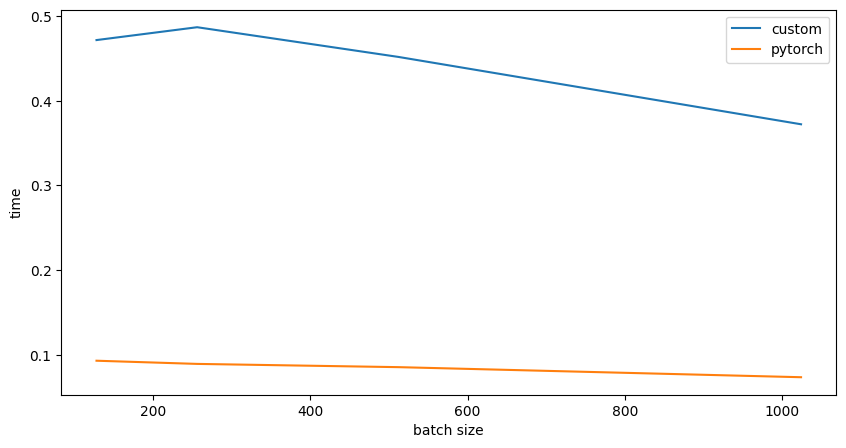

In [78]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(batch_size, times_custom, label="custom")
plt.plot(batch_size, times_pytorch, label="pytorch")
plt.xlabel("batch size")
plt.ylabel("time")
plt.legend()
plt.show()


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [89]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        # x = self.softmax(x)

        return x

In [90]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = NN(784, 10).to(device)
learning_rate = 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print(device)

cuda:0


In [91]:
batch_size = 32
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda

class CustomTransform:
    def __call__(self, img):
        return img*255

CustomTransform = CustomTransform()
transform_list = transforms.Compose([
    transforms.ToTensor(),
    CustomTransform,
])

train_data = torchvision.datasets.MNIST(root='/dataset', train=True, transform=transform_list, download=True)
trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

train_data, val_data = torch.utils.data.random_split(train_data, [53000, 7000])
valloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.MNIST(root='/dataset', train=False, transform=transform_list, download=True)
testloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define lists to store training, validation, and testing loss and accuracy
train_loss_list = []
test_loss_list = []
val_loss_list = []

train_acc_list = []
test_acc_list = []
val_acc_list = []

num_epochs = 60  # You can set the number of epochs as needed

for epoch in range(num_epochs):

    train_loss = 0
    correct = 0
    model.train()
    for idx, (images, labels) in enumerate(trainloader):

        images = images.reshape(images.shape[0], -1)

        images = images.to(device)
        labels = labels.to(device)

        score = model(images)
        loss = criterion(score, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        correct += (torch.argmax(score, dim=1) == labels).sum().item()

    train_acc = correct / len(train_data)
    train_loss = train_loss / len(trainloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    test_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(testloader):

            images = images.reshape(images.shape[0], -1)

            images = images.to(device)
            labels = labels.to(device)

            score = model(images)
            loss = criterion(score, labels)

            test_loss += loss.item()

            correct += (torch.argmax(score, dim=1) == labels).sum().item()

    test_acc = correct / len(test_data)
    test_loss = test_loss / len(testloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    val_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(valloader):

            images = images.reshape(images.shape[0], -1)

            images = images.to(device)
            labels = labels.to(device)

            score = model(images)
            loss = criterion(score, labels)

            val_loss += loss.item()

            correct += (torch.argmax(score, dim=1) == labels).sum().item()

    val_acc = correct / len(val_data)
    val_loss = val_loss / len(valloader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch {epoch + 1}, '
            f'Training Loss: {train_loss:.4f}, '
            f'Testing Loss: {test_loss:.4f}, '
            f'Validation Loss: {val_loss:.4f}, '
            f'Training Accuracy: {train_acc:.4f}, '
            f'Testing Accuracy: {test_acc:.4f}, '
            f'Validation Accuracy: {val_acc:.4f}')    

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Testing Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 0, Train Loss: 1.2307, Train Acc: 0.6164, Test Loss: 0.8351, Test Acc: 0.7610
Epoch 1, Train Loss: 0.7869, Train Acc: 0.7866, Test Loss: 0.7224, Test Acc: 0.8092
Epoch 2, Train Loss: 0.7146, Train Acc: 0.8145, Test Loss: 0.6799, Test Acc: 0.8258
Epoch 3, Train Loss: 0.6776, Train Acc: 0.8276, Test Loss: 0.6598, Test Acc: 0.8345
Epoch 4, Train Loss: 0.6532, Train Acc: 0.8356, Test Loss: 0.6388, Test Acc: 0.8389
Epoch 5, Train Loss: 0.6349, Train Acc: 0.8422, Test Loss: 0.6228, Test Acc: 0.8460
Epoch 6, Train Loss: 0.6202, Train Acc: 0.8467, Test Loss: 0.6134, Test Acc: 0.8491
Epoch 7, Train Loss: 0.6080, Train Acc: 0.8501, Test Loss: 0.6045, Test Acc: 0.8496
Epoch 8, Train Loss: 0.5975, Train Acc: 0.8540, Test Loss: 0.5964, Test Acc: 0.8555
Epoch 9, Train Loss: 0.5891, Train Acc: 0.8567, Test Loss: 0.5912, Test Acc: 0.8547
Epoch 10, Train Loss: 0.5812, Train Acc: 0.8591, Test Loss: 0.5855, Test Acc: 0.8582
Epoch 11, Train Loss: 0.5748, Train Acc: 0.8618, Test Loss: 0.5821, Test Ac

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torchvision

In [16]:
class NeuralNetwork:
    def __init__(self, N, A, lr, act_func, epochs, batchsize):
        self.N = N + 2 
        self.A = A
        self.lr = lr
        self.act_func = act_func
        self.epochs = epochs
        self.batchsize = batchsize
        self.loss = []
        self.train_acc = []
        self.wts = []
        self.biases = []
        self.val_loss = []
        self.val_acc = []
        self.test_loss = []
        self.test_acc = []

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def softmax_grad(self, z):
        return self.softmax(z) * (1 - self.softmax(z))

    def cross_entropy_loss(self, predictions, true_labels):
        
        epsilon = 1e-15  # Small constant to avoid taking the logarithm of zero
    
        # Clip predictions to avoid log(0)
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        # Add a small constant to avoid log(0)
        predictions = np.maximum(predictions, epsilon)
        
        # Calculate cross-entropy loss
        loss = -np.sum(true_labels * np.log(predictions)) / len(predictions)
        
        return loss

    def activation(self, z):

        if self.act_func == 'sigmoid':
            return 1 / (1 + np.exp(-z + 1e-8))
        elif self.act_func == 'relu':
            return np.maximum(0, z)
        elif self.act_func == 'softmax':
            return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def activation_grad(self, z):

        if self.act_func == 'sigmoid':
            return self.activation(z) * (1 - self.activation(z))
        elif self.act_func == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.act_func == 'softmax':
            return self.activation(z) * (1 - self.activation(z))

    def val_data(self, X_val, y_val):
        a = [X_val]
        for j in range(len(self.A) - 1):
            a.append(self.activation(np.dot(a[j], self.wts[j]) + self.biases[j]))

        a[-1] = self.softmax(a[-1])

        loss = self.cross_entropy_loss(a[-1], y_val)

        self.val_loss.append(loss)
        self.val_acc.append(self.accuracy(np.argmax(y_val, axis=1), np.argmax(a[-1], axis=1)))

    def test_data(self, X_test, y_test):
        a = [X_test]
        for j in range(len(self.A) - 1):
            a.append(self.activation(np.dot(a[j], self.wts[j]) + self.biases[j]))

        a[-1] = self.softmax(a[-1])

        loss = self.cross_entropy_loss(a[-1], y_test)

        self.test_loss.append(loss)
        self.test_acc = self.accuracy(np.argmax(y_test, axis=1), np.argmax(a[-1], axis=1))


    def fit(self, X, y, X_val, y_val, X_test, y_test):
        self.A.insert(0, X.shape[1])
        self.A.append(10)

        # for i in range(len(self.A) - 1):
        #     # random between 0 and 1
        #     self.wts.append(np.random.rand(self.A[i], self.A[i + 1]))
        #     self.biases.append(np.random.rand(1, self.A[i + 1]))

        # Xavier Initialization
        for i in range(len(self.A) - 1):
            self.wts.append(np.random.randn(self.A[i], self.A[i + 1]) * np.sqrt(1 / self.A[i]))
            self.biases.append(np.random.randn(1, self.A[i + 1]) * np.sqrt(1 / self.A[i]))

        print("Starting training...")

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batchsize):
                X_batch = X[i:i + self.batchsize]
                y_batch = y[i:i + self.batchsize]

                a = [X_batch]

                
                for j in range(len(self.A) - 1):
                    a.append(self.activation(np.dot(a[j], self.wts[j]) + self.biases[j]))

                # print("Activations:")
                # print(a)
                # print()
                # print("Weights:")
                # print(self.wts)
                # print()
                # print("Biases:")
                # print(self.biases)
                # print()

                # print("A ki shape is", a[-1].shape)
                # print("Labels ki shape is", y_batch.shape)

                # print(a[-1][0])
                # print(y_batch[0])
                
                a[-1] = self.softmax(a[-1])

                loss = self.cross_entropy_loss(a[-1], y_batch)

                # print(loss)


                delta = (a[-1] - y_batch) / self.batchsize

                for j in range(len(self.A) - 1, 0, -1):
                    self.wts[j - 1] -= self.lr * np.dot(a[j - 1].T, delta)
                    self.biases[j - 1] -= self.lr * np.sum(delta, axis=0)

                    delta = np.dot(delta, self.wts[j - 1].T) * self.activation_grad(a[j - 1])

            self.loss.append(loss)
            self.train_acc.append(self.accuracy(np.argmax(y_batch, axis=1), np.argmax(a[-1], axis=1)))
            self.val_data(X_val, y_val)
            self.test_data(X_test, y_test)
            print('Epoch:', epoch + 1, '/', self.epochs, 'Loss:', loss)

    def predict(self, X):
        a = [X]
        for j in range(len(self.A) - 1):
            a.append(self.activation(np.dot(a[j], self.wts[j]) + self.biases[j]))

        a[-1] = self.softmax(a[-1])

        return a[-1]

    def plot_loss(self):
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

In [17]:
# MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

X_train = trainset.data
y_train = trainset.targets

X_test = testset.data
y_test = testset.targets

X_train = X_train.reshape(X_train.shape[0], -1).numpy()
X_test = X_test.reshape(X_test.shape[0], -1).numpy()

y_train = y_train.numpy()
y_test = y_test.numpy()

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

X_train = X_train / 255
X_test = X_test / 255

# validation set is 10% of the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [18]:
nn = NeuralNetwork(N=4, A=[256, 128, 64, 32], lr=0.0003, act_func='relu', epochs=60, batchsize=32)
nn.fit(X_train, y_train, X_val, y_val, X_test, y_test)

Starting training...
Epoch: 1 / 60 Loss: 2.266064044816046
Epoch: 2 / 60 Loss: 2.2412538319424518
Epoch: 3 / 60 Loss: 2.1966829314741836
Epoch: 4 / 60 Loss: 2.1249951211135043
Epoch: 5 / 60 Loss: 2.0249141992511692
Epoch: 6 / 60 Loss: 1.868104539345968
Epoch: 7 / 60 Loss: 1.6543661878265539
Epoch: 8 / 60 Loss: 1.4900625661083327
Epoch: 9 / 60 Loss: 1.3400556422571952
Epoch: 10 / 60 Loss: 1.2078691926145793
Epoch: 11 / 60 Loss: 1.0765023433723135
Epoch: 12 / 60 Loss: 0.9503657562511586
Epoch: 13 / 60 Loss: 0.8415899378134308
Epoch: 14 / 60 Loss: 0.7476166160666142
Epoch: 15 / 60 Loss: 0.6719456718323051
Epoch: 16 / 60 Loss: 0.6148856994616548
Epoch: 17 / 60 Loss: 0.5700816267985003
Epoch: 18 / 60 Loss: 0.5296880388710827
Epoch: 19 / 60 Loss: 0.498724921147492
Epoch: 20 / 60 Loss: 0.47338086040913957
Epoch: 21 / 60 Loss: 0.4537415871584518
Epoch: 22 / 60 Loss: 0.43850650856029416
Epoch: 23 / 60 Loss: 0.4257948110572458
Epoch: 24 / 60 Loss: 0.4148384964054557
Epoch: 25 / 60 Loss: 0.405210

In [ ]:
y_pred = np.argmax(nn.predict(X_test), axis=1)
print(f'Accuracy: {nn.accuracy(np.argmax(y_test, axis=1), y_pred)}')

# plot all loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(nn.loss, label='Training Loss')
plt.plot(nn.val_loss, label='Validation Loss')
plt.plot(nn.test_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(nn.train_acc, label='Training Accuracy')
plt.plot(nn.val_acc, label='Validation Accuracy')
plt.plot(nn.test_acc, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()